In [27]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, GRU
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

Written by Ethan Reinhart and Andrew Wisniewski

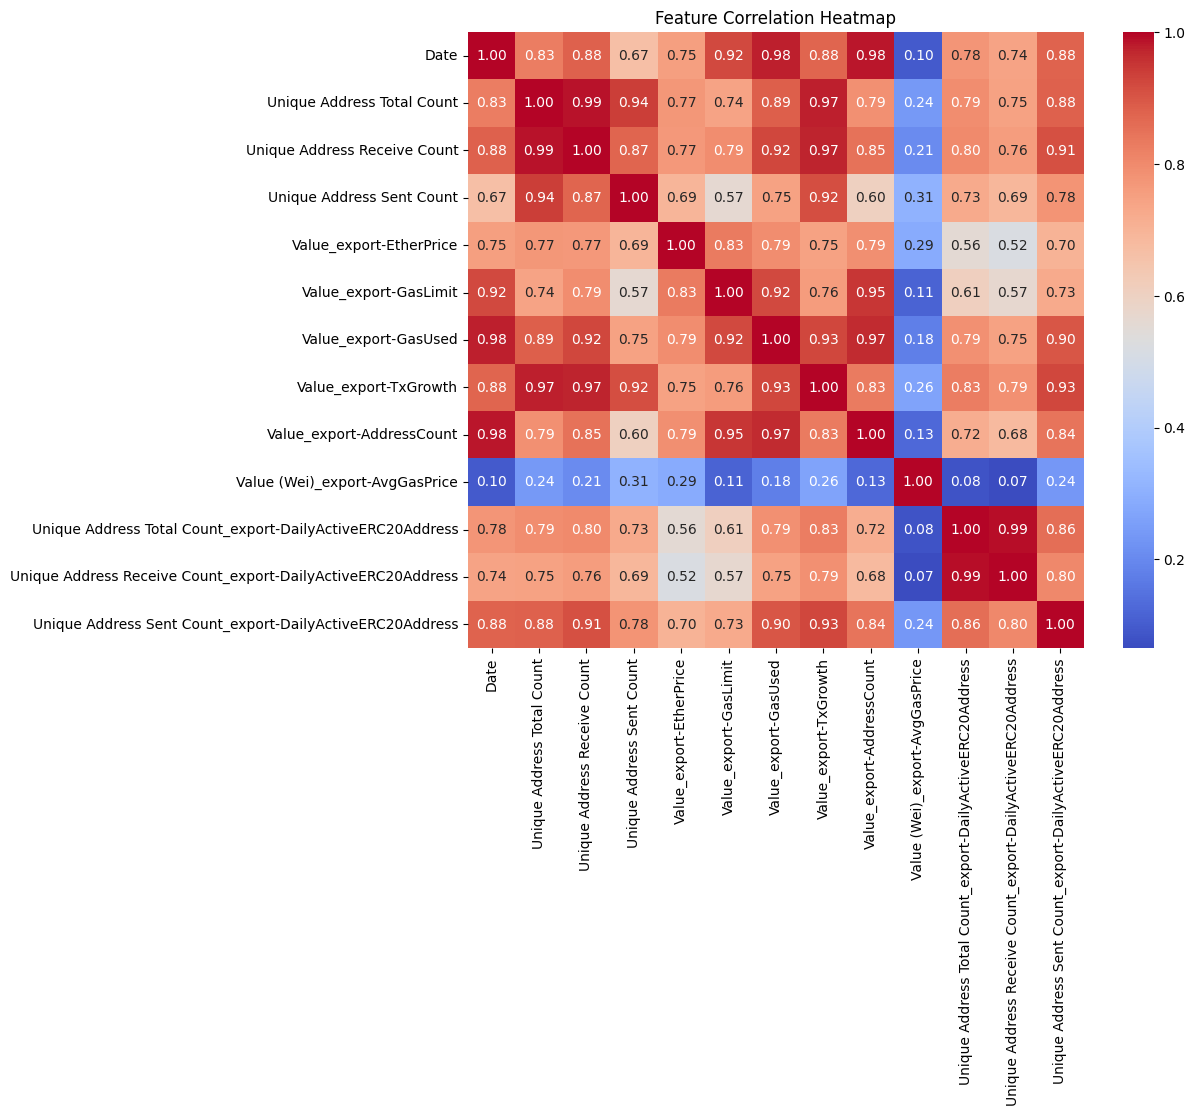

In [28]:
# 1. (Andrew) Conjoins the data, displays a confusion matrix.
# Debugging statement have been removed for brevity.

selected_files = [
    'export-DailyActiveEthAddress.csv',
    'export-EtherPrice.csv',
    'export-GasLimit.csv',
    'export-GasUsed.csv',
    'export-TxGrowth.csv',
    'export-AddressCount.csv',
    'export-AvgGasPrice.csv',
    'export-DailyActiveERC20Address.csv'
]

# Load the CSV files into dataframes
dfs = {}
for file in selected_files:
    df = pd.read_csv(f'./ethdata/{file}')
    dfs[file] = df

# Standardize the date column name in all files
for file, df in dfs.items():
    df.rename(columns={'Date(UTC)': 'Date'}, inplace=True)
    dfs[file] = df

# Drop unnecessary columns from all files and keep only relevant data
for file, df in dfs.items():
    cols_to_keep = [col for col in df.columns if col != 'UnixTimeStamp']
    dfs[file] = df[cols_to_keep]

# Initialize merged_df with the first DataFrame
merged_df = dfs[selected_files[0]]

for file in selected_files[1:]:
    suffix = file.split('.')[0]  # Extract the suffix from the file name
    df = dfs[file].add_suffix(f'_{suffix}')  # Add suffix to column names
    df.rename(columns={f'Date_{suffix}': 'Date'}, inplace=True)  # Rename the date column back to 'Date'
    
    # Ensure 'Date' columns are in the same format
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Perform the merge
    merged_df = pd.merge(merged_df, df, on='Date', how='outer')  # Merge on the 'Date' column with 'outer' merge
    
merged_df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

# Ensure all columns are numeric and drop any non-numeric or all-null columns
merged_df = merged_df.apply(pd.to_numeric, errors='coerce')
merged_df = merged_df.dropna(how='all', axis=1)

# Calculate the correlation matrix
corr_matrix = merged_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()


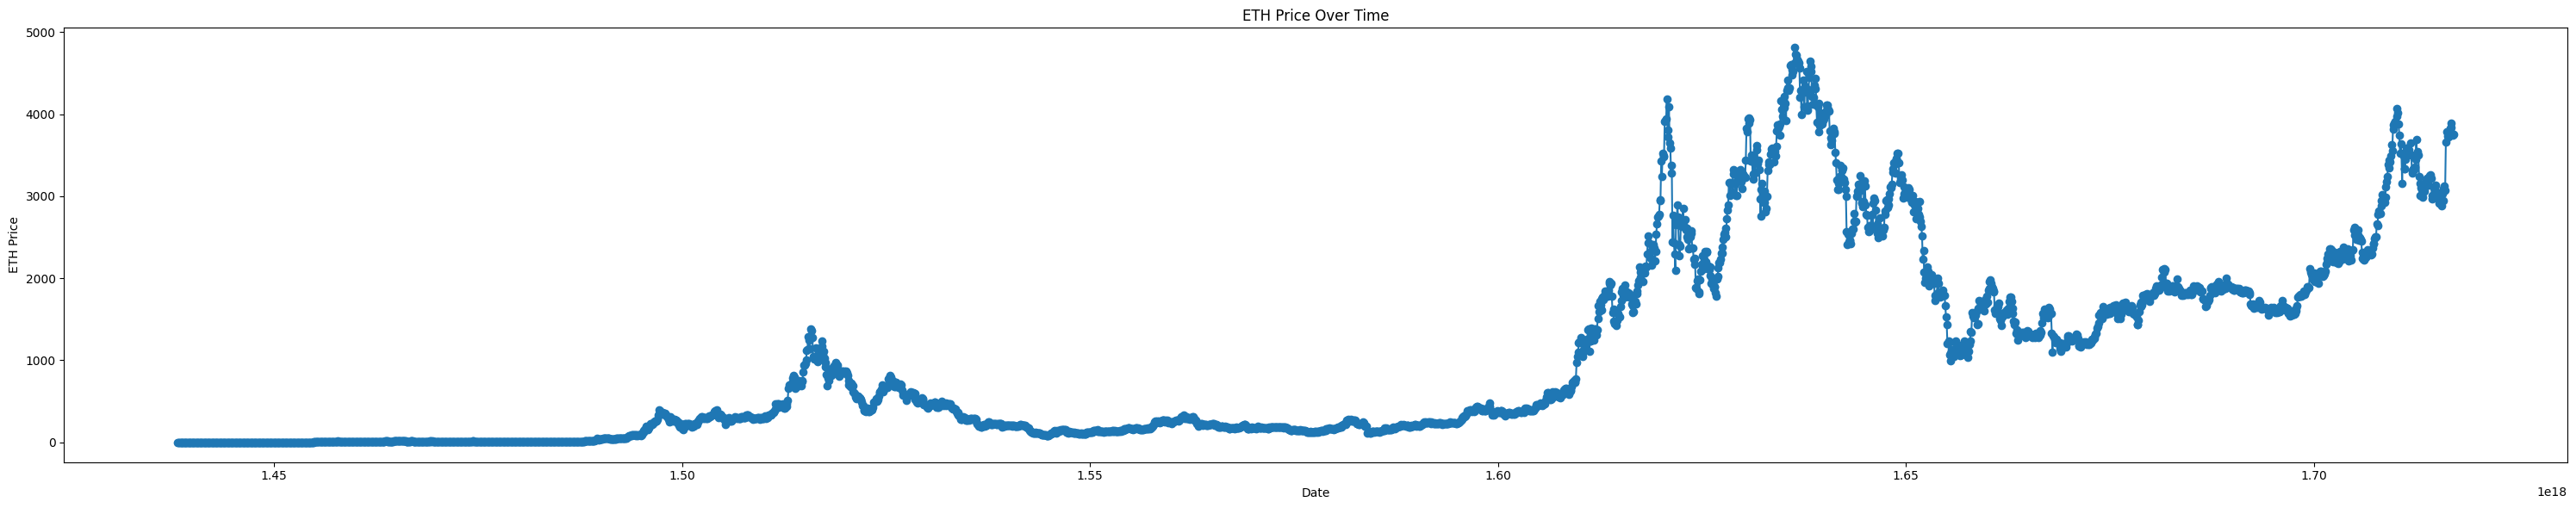

In [29]:
# 2. (Andrew) Displays a graph of historical Ether data.
plt.figure(figsize=(30, 6))
plt.plot(merged_df['Date'], merged_df['Value_export-EtherPrice'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.title('ETH Price Over Time')
plt.tight_layout()
plt.show()

In [30]:
# 3. (Ethan) Creation of the trainArgs class, holds hyperparameters for tuning the model. 
class trainArgs:
    def __init__(self, days_in_future, time_step, dropout, learning_rate, epochs, neurons, conv):
        # Days in future
        self._dif = days_in_future
        # Time Step
        self._ts = time_step
        self._dropout = dropout
        self._lr = learning_rate
        self._epochs = epochs
        self._neurons = neurons
        self._conv = conv
    
    @property
    def dif(self):
        return self._dif
    
    @property
    def ts(self):
        return self._ts
    
    @property
    def dropout(self):
        return self._dropout
    
    @property
    def lr(self):
        return self._lr
    
    @property
    def epochs(self):
        return self._epochs
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def conv(self):
        return self._conv
    

In [31]:
# 4. (Ethan/Andrew) Functions for parsing the data, time_step days will be used to make a prediction.
def create_dataset_one_feature(data):
    X, y = [], []
    for i in range(len(data) - tArgs.ts - 1 - tArgs.dif):
        X.append(data[i:(i + tArgs.ts), 0])
        y.append(data[i + tArgs.ts + tArgs.dif, 0])
    return np.array(X), np.array(y)

def create_dataset_two_feature(data):
    X, Y = [], []
    for i in range(len(data) - tArgs.ts - 1 - tArgs.dif):
        a = data[i:(i + tArgs.ts), :]
        X.append(a)
        Y.append(data[i + tArgs.ts + tArgs.dif, 0])
    return np.array(X), np.array(Y)

In [32]:
# 5. (Ethan) Defining specific hyperparameters for training the models.
days_in_future = 10
time_step = 200
dropout = 0.2
learning_rate = 0.001
train_size=0.8
epochs = 20
neuron_count = 64
conv = 64

tArgs = trainArgs(days_in_future, time_step, dropout, learning_rate, epochs, neuron_count, conv)

seed = 42
tf.random.set_seed(seed)
original_data = merged_df['Value_export-EtherPrice'].values

In [33]:
# 6. (Ethan/Andrew) 1-Feature LSTM model.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df['Value_export-EtherPrice'].values.reshape(-1,1))

X_train, y_train = create_dataset_one_feature(scaled_data[:int(len(scaled_data)*train_size)])
X_test, y_test = create_dataset_one_feature(scaled_data[int(len(scaled_data)*train_size):])


model = Sequential([
    Input(shape=(tArgs.ts, 1)),
    LSTM(tArgs.neurons, return_sequences=True),
    Dropout(tArgs.dropout),
    LSTM(tArgs.neurons),
    Dropout(tArgs.dropout),
    Dense(tArgs.conv),
    Dense(1)   
])


model.compile(optimizer=Adam(tArgs.lr), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=tArgs.epochs, batch_size=64)

test_loss = model.evaluate(X_test, y_test)

test_loss = np.array(math.sqrt(test_loss)).reshape(-1, 1)
test_loss = scaler.inverse_transform(test_loss)

print('RMSE:', test_loss)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


lstm_predicted_data = np.empty_like(original_data)
lstm_predicted_data[:] = np.nan
lstm_predicted_data[-len(predictions):] = predictions.reshape(-1)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0248
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030
Epoc

In [34]:
# 7. (Ethan/Andrew) 2-Feature LSTM model.
scaler_ether = MinMaxScaler()
scaler_gas = MinMaxScaler()

# Scale the data
scaled_data1 = scaler_ether.fit_transform(merged_df['Value_export-EtherPrice'].values.reshape(-1, 1))
scaled_data2 = scaler_gas.fit_transform(merged_df['Unique Address Total Count_export-DailyActiveERC20Address'].values.reshape(-1, 1))

# Combine the scaled data
scaled_data = np.hstack((scaled_data1, scaled_data2))

len_scaled_data = int(len(scaled_data)*train_size)
X_train, y_train = create_dataset_two_feature(scaled_data[:int(len_scaled_data)])
X_test, y_test = create_dataset_two_feature(scaled_data[int(len_scaled_data):])


model = Sequential([
    Input(shape=(tArgs.ts, 2)),
    LSTM(tArgs.neurons, return_sequences=True),
    Dropout(tArgs.dropout),
    LSTM(tArgs.neurons),
    Dropout(tArgs.dropout),
    Dense(tArgs.conv),
    Dense(1)
])

model.compile(optimizer=Adam(tArgs.lr), loss='mean_squared_error', metrics=['mse'])
model.fit(X_train, y_train, epochs=(tArgs.epochs), batch_size=64)

test_loss = model.evaluate(X_test, y_test)

test_loss = np.array(math.sqrt(test_loss[0])).reshape(-1, 1)
test_loss = scaler.inverse_transform(test_loss)[0][0]

print('RMSE:', test_loss)

predictions = model.predict(X_test)

predictions = scaler_ether.inverse_transform(predictions) # Inverse transform the predictions

y_test = scaler_ether.inverse_transform(y_test.reshape(-1, 1))
lstm2_predicted_data = np.empty_like(original_data)
lstm2_predicted_data[:] = np.nan
lstm2_predicted_data[-len(predictions):] = predictions.reshape(-1)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0303 - mse: 0.0303
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - mse: 0.0037
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mse: 0.0039
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - mse: 0.0035
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - mse: 0.0034
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - mse: 0.0037
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - mse: 0.0038
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - mse: 0.0033
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - mse: 0.0031
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - mse: 0.0033
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0029 - mse: 0.0029
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - mse: 0.0031
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━

In [35]:
# 8. (Ethan/Andrew) BiLSTM model.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df['Value_export-EtherPrice'].values.reshape(-1,1))

X_train, y_train = create_dataset_one_feature(scaled_data[:int(len(scaled_data)*train_size)])
X_test, y_test = create_dataset_one_feature(scaled_data[int(len(scaled_data)*train_size):])

forward_layer1 = LSTM(tArgs.neurons, return_sequences=True)
backward_layer1 = LSTM(tArgs.neurons, activation='relu', return_sequences=True, go_backwards=True)
forward_layer2 = LSTM(tArgs.neurons)
backward_layer2 = LSTM(tArgs.neurons, activation='relu', go_backwards=True)

# Build the model
model = Sequential([
    Input(shape=(tArgs.ts, 1)),
    Bidirectional(forward_layer1, backward_layer=backward_layer1),
    Dropout(tArgs.dropout),
    Bidirectional(forward_layer2, backward_layer=backward_layer2),
    Dropout(tArgs.dropout),
    Dense(tArgs.conv),
    Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(tArgs.lr), metrics=['mse'])
model.fit(X_train, y_train, epochs=int(tArgs.epochs / 2), batch_size=64)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_loss = np.array(math.sqrt(test_loss)).reshape(-1, 1)
test_loss = scaler.inverse_transform(test_loss)

print('RMSE:', test_loss)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

bilstm_predicted_data = np.empty_like(original_data)
bilstm_predicted_data[:] = np.nan
bilstm_predicted_data[-len(predictions):] = predictions.reshape(-1)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - loss: 0.0208 - mse: 0.0208
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - loss: 0.0036 - mse: 0.0036
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - loss: 0.0037 - mse: 0.0037
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 390ms/step - loss: 0.0033 - mse: 0.0033
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - loss: 0.0030 - mse: 0.0030
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - loss: 0.0033 - mse: 0.0033
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 411ms/step - loss: 0.0034 - mse: 0.0034
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 413ms/step - loss: 0.0031 - mse: 0.0031
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 419ms/step - loss: 0.0029 - mse: 0.0029
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 407ms/step - loss: 0.0029 - mse: 0.0029
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0027 - mse: 0.0027
RMSE: [[286.11320959]]
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step


****GRU****

In [36]:
# 9. (Ethan/Andrew) GRU model.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df['Value_export-EtherPrice'].values.reshape(-1,1))

X_train, y_train = create_dataset_one_feature(scaled_data[:int(len(scaled_data)*train_size)])
X_test, y_test = create_dataset_one_feature(scaled_data[int(len(scaled_data)*train_size):])

# Build the model
model = Sequential([
    Input(shape=(tArgs.ts, 1)),
    GRU(tArgs.neurons, return_sequences=True),
    Dropout(tArgs.dropout),
    GRU(tArgs.neurons),
    Dropout(tArgs.dropout),
    Dense(tArgs.conv),
    Dense(1)
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(tArgs.lr), metrics=['mse'])
model.fit(X_train, y_train, epochs=tArgs.epochs, batch_size=64)

test_loss, test_accuracy = model.evaluate(X_test, y_test)

test_loss = np.array(math.sqrt(test_loss)).reshape(-1, 1)
test_loss = scaler.inverse_transform(test_loss)

print('RMSE:', test_loss)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

gru_predicted_data = np.empty_like(original_data)
gru_predicted_data[:] = np.nan
gru_predicted_data[-len(predictions):] = predictions.reshape(-1)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0383 - mse: 0.0383
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037 - mse: 0.0037
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - mse: 0.0033
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mse: 0.0034
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0032 - mse: 0.0032
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0038 - mse: 0.0038
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035 - mse: 0.0035
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - mse: 0.0031
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - mse: 0.0033
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - mse: 0.0030
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029 - mse: 0.0029
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034 - mse: 0.0034
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━

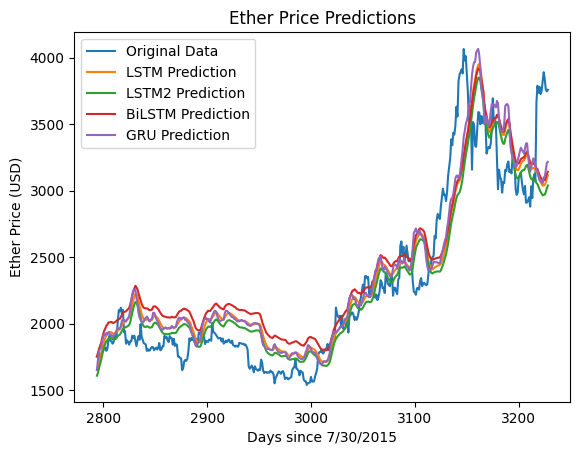

In [37]:
# 10. (Ethan/Andrew) Graph of models.
from_original = np.full_like(original_data, np.nan)
from_original[-(len(predictions)):] = original_data[-len(predictions):]

plt.plot(from_original, label='Original Data')
plt.plot(lstm_predicted_data, label='LSTM Prediction')
plt.plot(lstm2_predicted_data, label='LSTM2 Prediction')
plt.plot(bilstm_predicted_data, label='BiLSTM Prediction')
plt.plot(gru_predicted_data, label='GRU Prediction')
plt.xlabel('Days since 7/30/2015')
plt.ylabel('Ether Price (USD)')
plt.title('Ether Price Predictions')
plt.legend()
plt.show()